## Introduction

À partir de dizaines de milliers de tweets recueillis suivant le premier débat de la primaire républicaine du 6 août 2015 en Ohio, une étude d'analyse de sentiment et de catégorisation des tweets a été réalisée à la main par des contributeurs. Les contributeurs devaient indiquer si le tweet était pertinent, quel candidat était mentionné dans le tweet, quel sujet était abordé dans le tweet et fianlement quel était le sentiment général qui en ressortait. Tous les tweets non-pertinents furent retirés du jeu de données.

In [154]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
from pathlib import Path

data_folder = Path('/Users/quentintabourin/Desktop/HEC_A2020/M80629 - apprentissage automatique/projet/')

GOP = pd.read_csv(data_folder/'GOP_Sentiment.csv') 

In [5]:
GOP.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [6]:
print(GOP.shape[0],GOP.shape[1])

13871 21


Index(['id', 'candidate', 'candidate_confidence', 'relevant_yn',
       'relevant_yn_confidence', 'sentiment', 'sentiment_confidence',
       'subject_matter', 'subject_matter_confidence', 'candidate_gold', 'name',
       'relevant_yn_gold', 'retweet_count', 'sentiment_gold',
       'subject_matter_gold', 'text', 'tweet_coord', 'tweet_created',
       'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

## missing values

In [56]:
perc = (GOP.isna().sum()/len(GOP)*100).round(1)
misscount = GOP.isna().sum()
missingtbl = pd.concat([perc.to_frame(), misscount.to_frame()], axis = 1)
missingtbl.columns = ['perc', 'misscount']
missingtbl

,perc,misscount
id,0.0,0
candidate,0.7,96
candidate_confidence,0.0,0
relevant_yn,0.0,0
relevant_yn_confidence,0.0,0
sentiment,0.0,0
sentiment_confidence,0.0,0
subject_matter,2.4,326
subject_matter_confidence,0.0,0
candidate_gold,99.8,13843


La base de données contient 21 colonnes et un total de 13871 observations

On peut voir que les colonnes 'candidate_gold', 'relevant_yn_gold', 'sentiment_gold', 'subject_matter_gold' et 'tweet_coord' n'ont presque que des valeurs manquantes. On peut retirer ces colonnes de la base de données.

On peut voir que dans les autres données qui peuvent nous intéresser, il manque 96 valeurs pour la variable 'candidate' et 326 pour 'subject_matter', soit respectivement 0.7% et 2.4% des données, ce qui est faible. 
Par contre, il manque 28.2% des données pour 'tweet-location' et 'user_timezone'.

Finalement, les deux variables qui nous importent le plus, soit 'sentiment' et 'text' ne comportent pas de valeurs manquantes.

In [85]:
GOP_old = GOP.copy()
GOP = GOP.copy().drop(['candidate_gold', 'relevant_yn_gold', 'sentiment_gold', 'subject_matter_gold','tweet_coord'], axis =1)
GOP.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,name,retweet_count,text,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,I_Am_Kenzi,5,RT @NancyLeeGrahn: How did everyone feel about...,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,PeacefulQuest,26,RT @ScottWalker: Didn't catch the full #GOPdeb...,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,PussssyCroook,27,RT @TJMShow: No mention of Tamir Rice and the ...,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,MattFromTexas31,138,RT @RobGeorge: That Carly Fiorina is trending ...,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,sharonDay5,156,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


## évaluation des confidence pour les variables 'candidate', 'relevant_yn', 'sentiment' et subject_matter'

yes    13871
Name: relevant_yn, dtype: int64


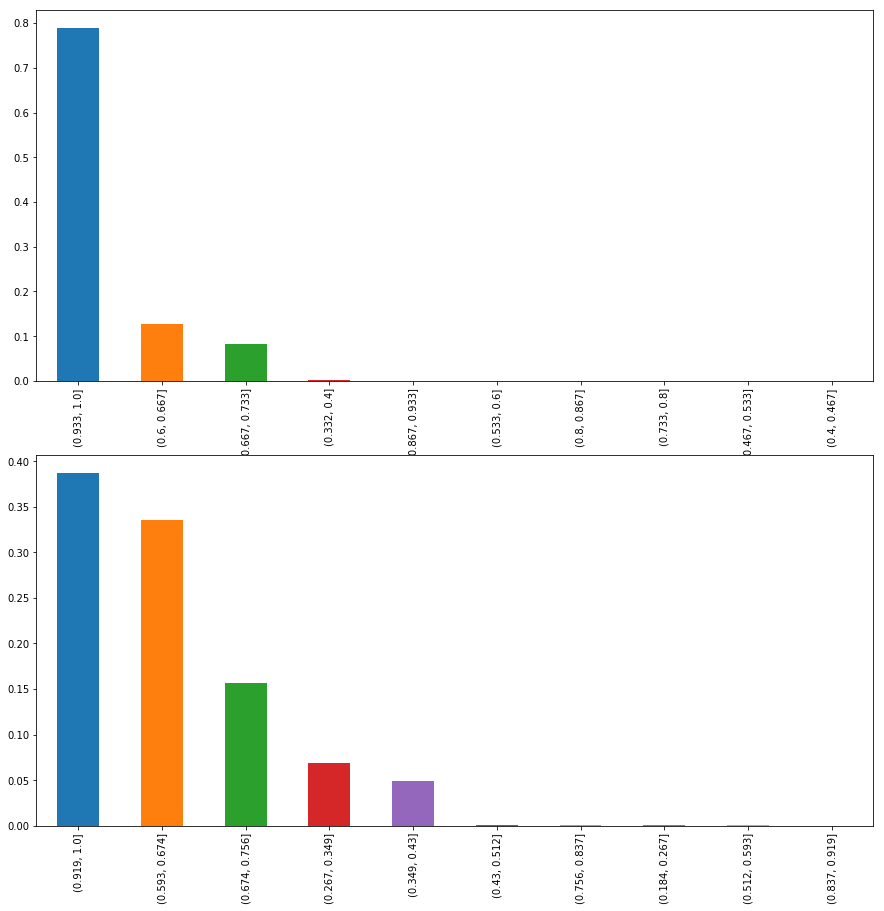

In [141]:
print(GOP.relevant_yn.value_counts())

fig, axs = plt.subplots(2,figsize=(15,15))

GOP.relevant_yn_confidence.value_counts(bins = 10, normalize = True).plot(kind = 'bar', ax = axs[0])
GOP.sentiment_confidence.value_counts(bins = 10, normalize = True).plot(kind = 'bar', ax = axs[1])


In [142]:
#GOPnonrelev = GOP.loc[GOP.relevant_yn_confidence<0.9].reset_index()
#GOPnonrelev.loc[GOPnonrelev.candidate.isna()]


In [143]:
#GOPnonrelev.loc[GOPnonrelev.relevant_yn_confidence<=0.57]

Suivant la variable 'relevant_yn' qui indique si le message du tweet est pertinent ou non, tous les tweets sont pertinents. Toutefois, en observant la confiance des valeurs de pertinence ('relevant_yn_confidence'), on observe que près de 80% sont véritablement pertinents (confiance supérieure à 0.9) mais que 21% ont une confiance inférieure à 0.667, avec des confiance aussi bas que 0.4.

De même pour la confiance concernant le sentiment, seulement 40% sont environ égal à 1.

Nous n'avons cependant pas d'information sur comment ont été calculés ces 'confidence' et ce qu'ils représentent en terme de précison et de pertinence.

## répartition des observations pour candidat mentionné et sujet traité

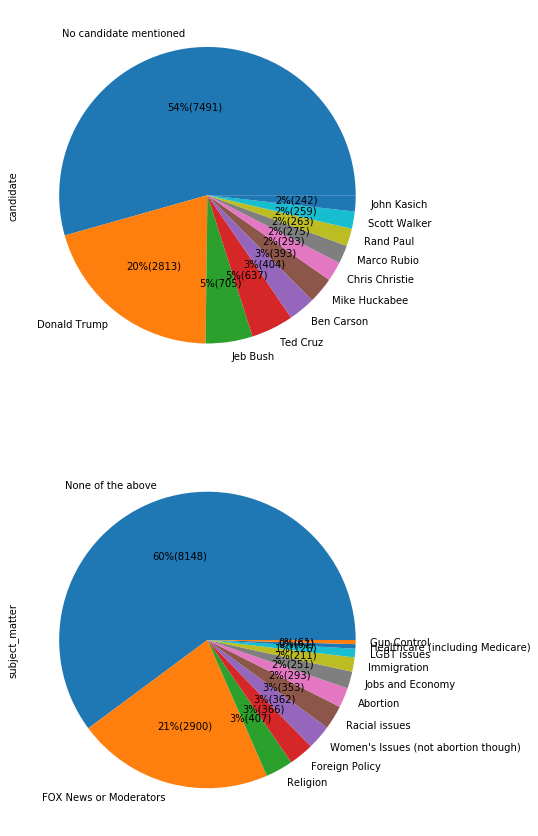

In [6]:
fig, axs = plt.subplots(2,figsize=(15,15))
GOP.candidate.value_counts().plot(kind='pie', autopct=lambda 
                                  p: '{:1.0f}%({:.0f})'.format(p,(p/100)*GOP.groupby('candidate').size().sum()), ax = axs[0])
GOP.subject_matter.value_counts().plot(kind='pie', autopct=lambda 
                                  p: '{:1.0f}%({:.0f})'.format(p,(p/100)*GOP.groupby('subject_matter').size().sum()), ax = axs[1])


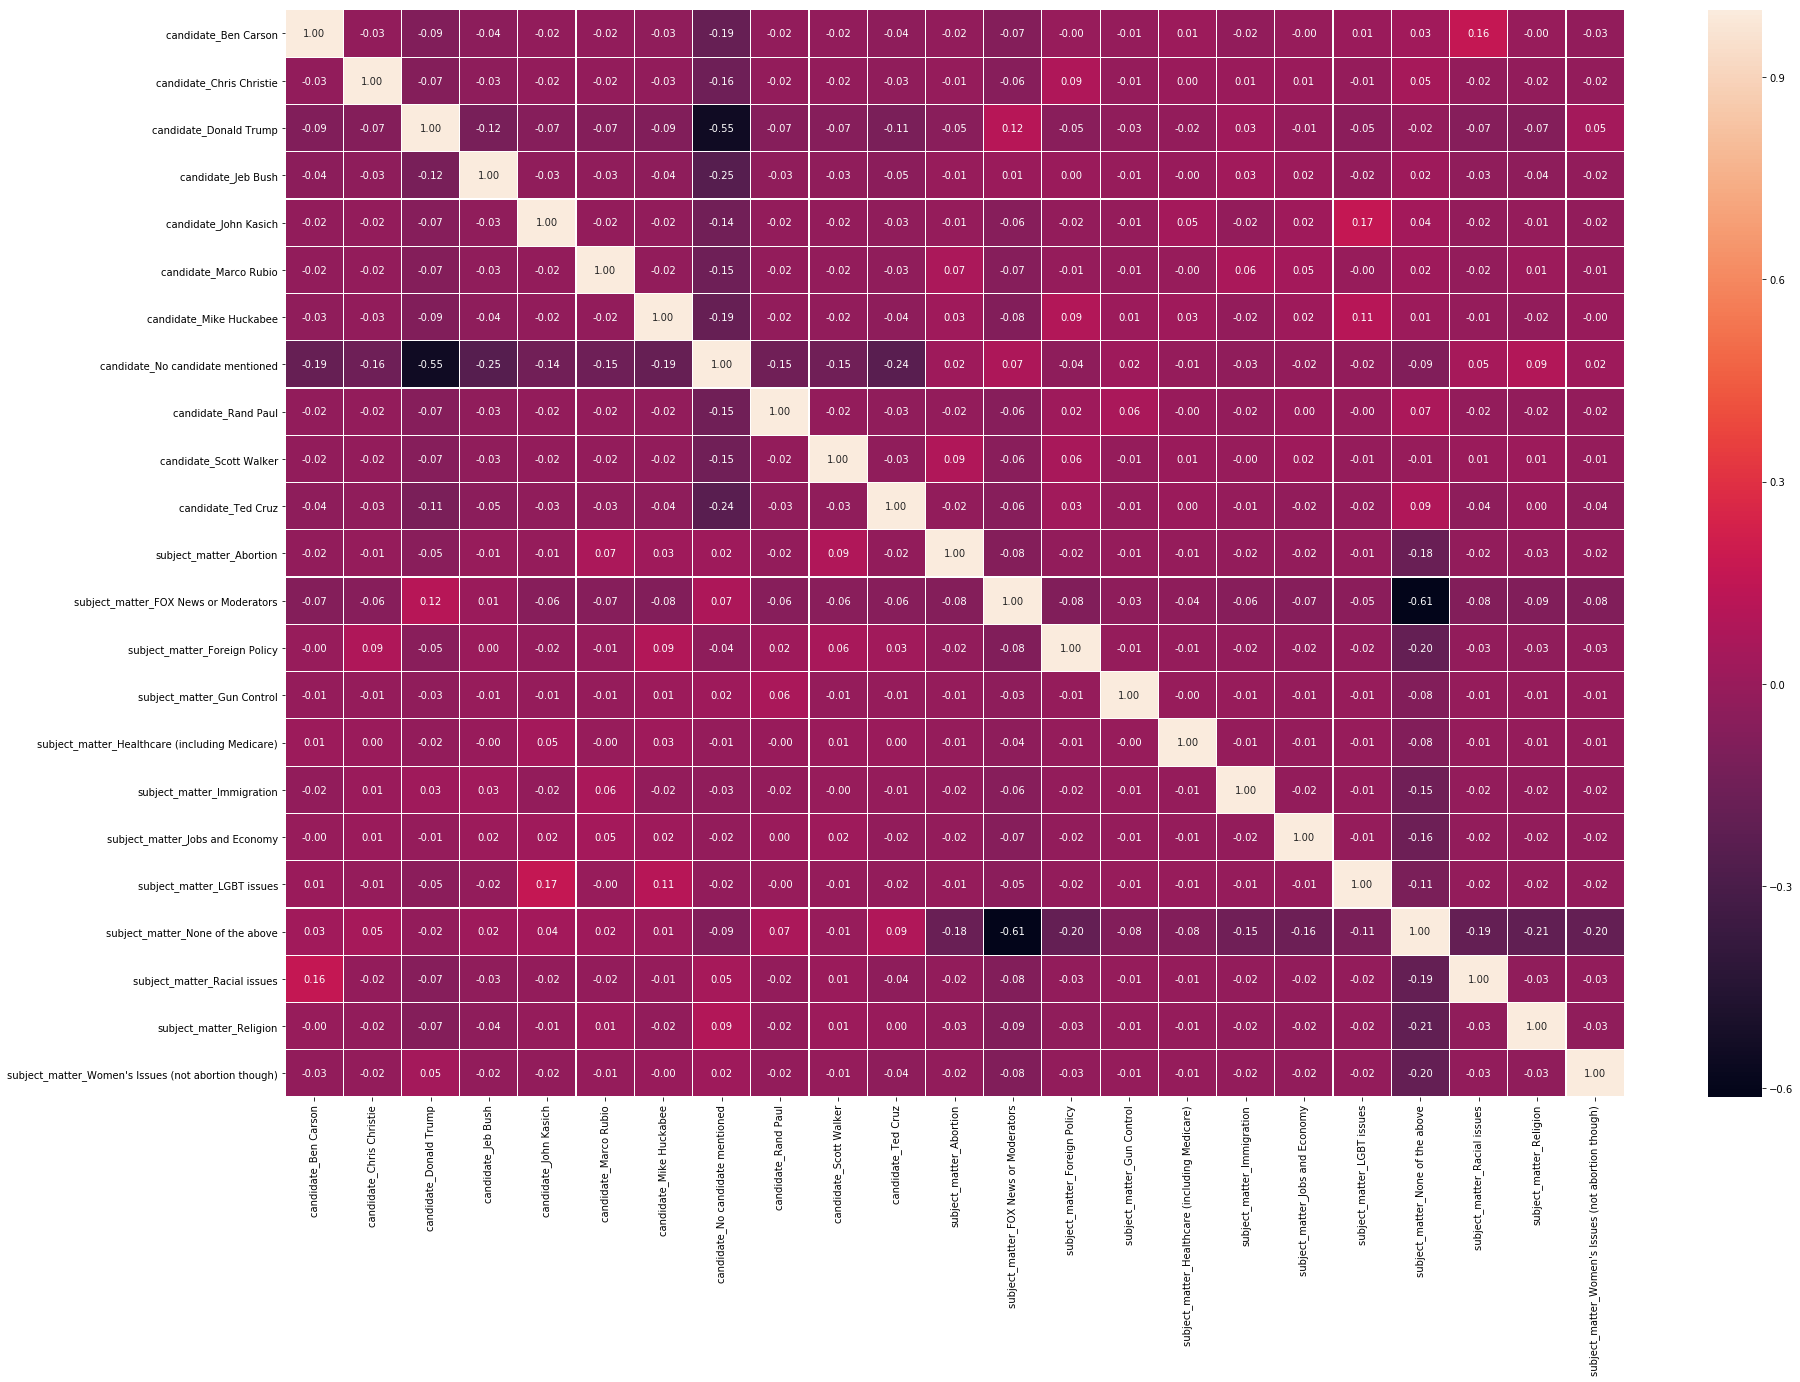

In [179]:
GOP_corr = GOP[['candidate','subject_matter']]
GOP_corr = pd.get_dummies(GOP_corr)
GOP_corr
GOP_corr = GOP_corr[GOP_corr.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(GOP_corr, annot = True, linewidths=0.2, fmt=".2f")

On peut tout d'abord voir que la majorité des tweets ne mentionnent pas un candidat en particulier (54%) et le candidat qui majoritairement cité est Donald Trump (20%). Les autrea candidats ne sont mentionnés 5% des fois pour Jeb Bush et Ted Cruz et 3% ou moins pour les autres.

Une grande disparité des mentions est également présent dans les sujets mentionnés. Encore une fois, plus de la moitié des tweets (60%) ne mentionnent pas un des 11 sujets prévus pour l'identification par les collaborateurs. Le sujet le plus mentionnés concerne la chaîne FOX News ou ses modérateurs du débat (chaîne sur laquelle s'est déroulée le débat).

Toutefois, en analysant la corrélation entre le candidat mentionné et le sujet mentionné, on voit que ceux-ci ne sont pas corrélés ensemble. La réponse aucun candidat mentionné et aucun sujet mentionné ont une corrélation de -0.09

## Sentiment

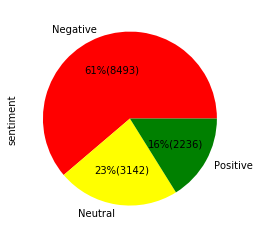

In [7]:
GOP.sentiment.value_counts().plot(kind='pie', autopct=lambda 
                                  p: '{:1.0f}%({:.0f})'.format(p,(p/100)*GOP.groupby('sentiment').size().sum()),
                                  colors=["red", "yellow", "green"])


Le sentiment va être dans notre analyse la variable réponse (y). Afin de pouvoir bien entraîner le modèle, il est préférable que les groupes soient bien distribués. Le dataset contient trois groupes d'expression de sentiment dans le tweet soit:
 - sentiment négatif
 - sentiment neutre
 - sentiment positif
     

Près de 60% des tweets sont négatifs, 23% ont neutres et 16% sont positifs. On a une bonne répartition des sentiments et un nombre assez élevé dans chaque catégorie pour pouvoir diviser en échantillon d'entraînement et en échantillon de test

## corrélation entre la variable réponse 'sentiment' et les autres variables

In [185]:
from scipy.stats import chi2
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [187]:
GOP2 = GOP[['candidate', 'sentiment', 'subject_matter','tweet_location','user_timezone','text']]
c = GOP2.shape[1]
confu_mat = np.zeros((c,c))


for i in range(c):

    for j in range(c):
        confu_mat[i,j] = cramers_v(GOP2.iloc[:,i],GOP2.iloc[:,j])
    
pd.DataFrame(confu_mat, columns = GOP2.columns, index = GOP2.columns )

,candidate,sentiment,subject_matter,tweet_location,user_timezone,text
candidate,1.000000,0.235116,0.140532,0.049782,0.000000,0.490380
sentiment,0.235116,1.000000,0.182612,0.171121,0.063542,0.361727
subject_matter,0.140532,0.182612,1.000000,0.183200,0.045003,0.458691
tweet_location,0.049782,0.171121,0.183200,1.000000,0.640605,0.000000
user_timezone,0.000000,0.063542,0.045003,0.640605,1.000000,0.000000
text,0.490380,0.361727,0.458691,0.000000,0.000000,1.000000


**À voir comment analyser ce tableau de corrélation**

*C'est une corrélation basée sur le test Cramer's V* **A expliquer**